In [218]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker
from os.path import join
import os
import json

# Constants and reusable functions

In [334]:
N_VECTORS = 1e6
ONE_MB = 2 ** 20
FLOAT_SIZE_B = 4
VECTOR_DIM = 128
VECTOR_SIZE = VECTOR_DIM * FLOAT_SIZE_B
VECTOR_SIZE_MB = VECTOR_SIZE / ONE_MB
N_QUERY_VECTORS = 1e4
NS_PER_S = 1e9
S_PER_MIN = 60
MS_PER_S = 1e3
US_TO_NS = 1e3

Reusable functions for parsing and preprocessing

In [220]:
# read benchmark parameters like `n_lists` and `n_probes` which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

def get_abbreviation_to_param_map():
    with open('parameter_abbreviations.json') as f:
        abbreviations = json.load(f)
    return {v: k for k, v in abbreviations.items()}

def get_file_params(filename):
    params = {}
    abbr_to_param = get_abbreviation_to_param_map()
    # remove .xml  extension explicitly
    filename = filename[:-4]
    catch_tags, params_str = filename.split(' ', 1)
    params['catch_tags'] = catch_tags
    for part in params_str.split(' '):
        key, value = part.split('=')
        params[abbr_to_param.get(key, key)] = value
    return params

def parse_xml(subdir, filename, format='throughput'):
    directory = join('benchmarks', subdir) if subdir else 'benchmarks'
    filepath = join(directory, filename)
    tree = ET.parse(filepath)
    root = tree.getroot()
    results = []

    if format == 'throughput':
        for match in root.iter('BenchmarkResults'):
            result = extract_benchmark_params(match)
            result['mean'] = match.find('mean').get('value')
            result['std'] = match.find('standardDeviation').get('value')
            results.append(result)
    elif format == 'latency':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('latency_99th'):
                continue
            result = extract_benchmark_params(match)
            result['latency_99th'] = match.text.split(':=')[1].strip()
            results.append(result)
    elif format == 'recall':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('Recall'):
                continue
            result = extract_benchmark_params(match)
            result['recall@1'] = match.text.split(':=')[1].strip()
            results.append(result)
    else:
        raise ValueError('Unknown format: {}'.format(format))

    return results

In [335]:
def results_to_df(results):
    df = pd.DataFrame(results)

    columns = []

    if 'O' in df.columns:
        df['O'] = df['O'].astype(int)
        columns += ['O']

    if 'max_n_threads' in df.columns:
        df['max_n_threads'] = df['max_n_threads'].astype(int)
        columns += ['max_n_threads']

    if 'n_lists' in df.columns:
        df['n_lists'] = df['n_lists'].astype(int)
        columns += ['n_lists']

    if 'n_probes' in df.columns:
        df['n_probes'] = df['n_probes'].astype(int)
        columns += ['n_probes']

    if 'n_results' in df.columns:
        df['n_results'] = df['n_results'].astype(int)
        columns += ['n_results']
        
    if 'mean' in df.columns:
        df['mean'] = df['mean'].astype(float) / NS_PER_S / N_QUERY_VECTORS
        columns += ['mean']

    if 'std' in df.columns:
        df['std'] = df['std'].astype(float) / NS_PER_S / N_QUERY_VECTORS
        columns += ['std']
    
    if 'latency_50th' in df.columns:
        df['latency_50th'] = df['latency_50th'].astype(float) / NS_PER_S
        columns += ['latency_50th']

    if 'latency_95th' in df.columns:
        df['latency_95th'] = df['latency_95th'].astype(float) / NS_PER_S
        columns += ['latency_95th']

    if 'latency_99th' in df.columns:
        df['latency_99th'] = df['latency_99th'].astype(float) / NS_PER_S
        columns += ['latency_99th']

    if 'recall@1' in df.columns:
        df['recall@1'] = df['recall@1'].astype(float)
        columns += ['recall@1']

    return df[columns]

Search space size for the vector search and search_preassigned
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probes`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

In [222]:
def add_space_estimates(df):
  df['n_vectors_to_search'] = (N_VECTORS / df['n_lists'] * df['n_probes']).round(1)
  df['search_space_size_mb'] = (df['n_vectors_to_search'] * VECTOR_SIZE_MB).round(1)
  df['centroids_total_size_mb'] = (df['n_lists'] * VECTOR_SIZE_MB).round(1)

Plotting

In [371]:
def plot(df, y_col, ylabel, title, yerr_col=None, legend_loc='best', yformatter=ticker.ScalarFormatter(), yaxis_log=False, mode='n_probes'):
    if mode == 'n_probes':
        x_col = 'n_probes'
        series_col = 'n_lists'
        x_label = 'Number of probes'
        legend_title = 'Number of lists'
    elif mode == 'n_lists':
        x_col = 'n_lists'
        series_col = 'n_probes'
        x_label = 'Number of lists'
        legend_title = 'Number of probes'
    elif mode == 'max_n_threads':
        x_col = 'max_n_threads'
        series_col = 'O'
        x_label = 'Max number of threads'
        legend_title = 'Optimization level'
    elif mode == 'n_results':
        x_col = 'n_results'
        series_col = 'n_probes'
        x_label = 'Number of results'
        legend_title = 'Number of probes'
    else:
        raise ValueError(f'Invalid value for plot: {plot}')
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_prop_cycle(marker_cycler)
    ax.set_title(title)
    sorted_uniques = sorted(df[series_col].unique())
    for n_lists in reversed(sorted_uniques):
        params = {'markersize': 7, 'lw': 2, 'label': f'{n_lists}'}
        df_subset = df[df[series_col] == n_lists]
        if yerr_col:
            params = {**params, 'capsize': 8, 'capthick': 1}
            ax.errorbar(x=df_subset[x_col], y=df_subset[y_col], yerr=df_subset[yerr_col], **params)
        else:    
            ax.plot(df_subset[x_col], df_subset[y_col], **params)

    ax.set_xlabel(x_label)
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    if yaxis_log:
        ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(yformatter)

    ax.legend(title=legend_title, loc=legend_loc)
    plt.show()

marker_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                         '#bcbd22', '#17becf'], marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

s_to_ms_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x*1000))
s_to_us_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x*1e6))
mb_to_gb_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x/2**10))
speedup_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x))


Throughput

In [224]:
def get_vector_throughput(df, n_vectors_column, seconds_column):
    vectors_per_s = (df[n_vectors_column] / df[seconds_column]).round(1)
    mb_per_s = (vectors_per_s * VECTOR_SIZE / ONE_MB).round(1)
    return vectors_per_s, mb_per_s

def add_centroids_search_throughput(centroids_df):
    centroids_df['vectors_per_s'], centroids_df['mb_per_s'] = get_vector_throughput(centroids_df, 'n_lists', 'mean')
    return centroids_df

def add_search_throughput(search_df):
  search_df['n_vectors_per_s'], search_df['mb_per_s'] = get_vector_throughput(search_df, 'n_vectors_to_search', 'mean')
  return search_df

Speedup

In [225]:
def get_speedup(old_df, new_df, column, invert=False):
  speedup = new_df[column] / old_df[column]
  if invert:
    speedup = 1 / speedup
  return speedup

# `bulk_insert_entries`

**Sorted vs Unsorted**

In [226]:
bie_unsorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.02024e+09, 'std': 4.9847e+06}, {'n_lists': 1024, 'n_probes': 1, 'mean': 5.54063e10, 'std': 1.41458e09}]
unsorted_df = results_to_df(bie_unsorted)
unsorted_df

,n_lists,n_probes,mean,std
0,512,1,0.000202,4.984700e-07
1,1024,1,0.005541,1.414580e-04


In [227]:
bie_sorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.84686e+09, 'std': 1.1119e+07},{'n_lists': 1024, 'n_probes': 1, 'mean': 3.68418e+09, 'std': 7.2396e07}]
sorted_df = results_to_df(bie_sorted)
sorted_df['mean_speedup'] = get_speedup(old_df=unsorted_df, new_df=sorted_df, column='mean', invert=True)
sorted_df

,n_lists,n_probes,mean,std,mean_speedup
0,512,1,0.000285,0.000001,0.709638
1,1024,1,0.000368,0.000007,15.038977


# No SIMD, No OpenMP

## `preassign_query()`

Parsing measurements from xml output of testing framework

In [228]:
centroids_df = results_to_df(parse_xml('Vanilla', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=0 SIM=0 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_df)
add_centroids_search_throughput(centroids_df)
centroids_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,16,0.000032,1.748240e-07,3906.2,1.9,0.1,8013171.7,3912.7
1,256,2,16,0.000032,4.385050e-08,7812.5,3.8,0.1,7938723.0,3876.3
2,256,4,16,0.000033,5.052130e-08,15625.0,7.6,0.1,7761738.9,3789.9
3,256,8,16,0.000034,5.839940e-09,31250.0,15.3,0.1,7477050.4,3650.9
4,256,16,16,0.000036,1.348230e-08,62500.0,30.5,0.1,7013737.1,3424.7
5,256,32,16,0.000041,6.347200e-08,125000.0,61.0,0.1,6306661.4,3079.4
6,256,64,16,0.000046,9.040590e-08,250000.0,122.1,0.1,5540274.1,2705.2
7,256,128,16,0.000053,1.135380e-07,500000.0,244.1,0.1,4822708.9,2354.8
8,512,1,16,0.000064,5.988300e-08,1953.1,1.0,0.2,8057827.5,3934.5
9,512,2,16,0.000064,9.919190e-08,3906.2,1.9,0.2,8004715.3,3908.6


**Search Space Size**

Here, we see how the search space behaves as we increase the number of lists and probes.
- The search space for the search_preassigned, i.e. `preassign_query`, grows linearly but only in proportion to the number of lists.


In [229]:
centroids_mean_by_n_lists_df = centroids_df.groupby('n_lists').mean()
centroids_std_by_n_lists_df = centroids_df.groupby('n_lists').std()
centroids_mean_by_n_lists_df

,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_lists,,,,,,,,,
256,31.875,16.0,0.000038,6.949174e-08,124511.7125,60.7875,0.1,6.859258e+06,3349.2375
512,31.875,16.0,0.000073,5.953118e-08,62255.8500,30.4000,0.2,7.192811e+06,3512.1250
1024,31.875,16.0,0.000138,7.002431e-08,31127.9250,15.2000,0.5,7.496177e+06,3660.2500
2048,31.875,16.0,0.000266,1.597557e-07,15563.9625,7.6000,1.0,7.714824e+06,3767.0125
4096,31.875,16.0,0.000524,2.639253e-06,7781.9750,3.8000,2.0,7.834094e+06,3825.2250


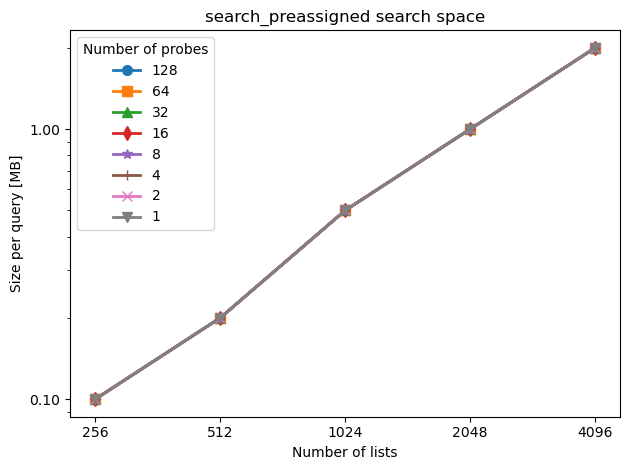

In [230]:
plot(centroids_df, 'centroids_total_size_mb', 'Size per query [MB]', 'search_preassigned search space', mode='n_lists', yaxis_log=True)

In [231]:
centroids_mean_by_n_probe_df = centroids_df.groupby('n_probes').mean()
centroids_std_by_n_probe_df = centroids_df.groupby('n_probes').std()
centroids_mean_by_n_probe_df

,n_lists,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_probes,,,,,,,,,
1,1587.2,16.0,0.000196,6.972355e-07,1513.66,0.74,0.76,8069669.16,3940.26
2,1587.2,16.0,0.000197,6.384280e-07,3027.34,1.48,0.76,8025824.48,3918.86
4,1587.2,16.0,0.000198,5.208156e-07,6054.68,2.96,0.76,7945382.62,3879.58
8,1587.2,16.0,0.000200,6.235480e-07,12109.36,5.92,0.76,7820442.94,3818.56
16,1587.2,16.0,0.000204,7.489974e-07,24218.74,11.82,0.76,7572021.82,3697.30
32,1587.2,16.0,0.000209,1.005184e-07,48437.50,23.64,0.76,7207163.60,3519.12
64,1587.2,16.0,0.000220,6.985802e-07,96875.00,47.30,0.76,6683086.06,3263.24
128,1587.2,16.0,0.000238,7.687666e-07,193750.00,94.60,0.76,6031874.58,2945.24


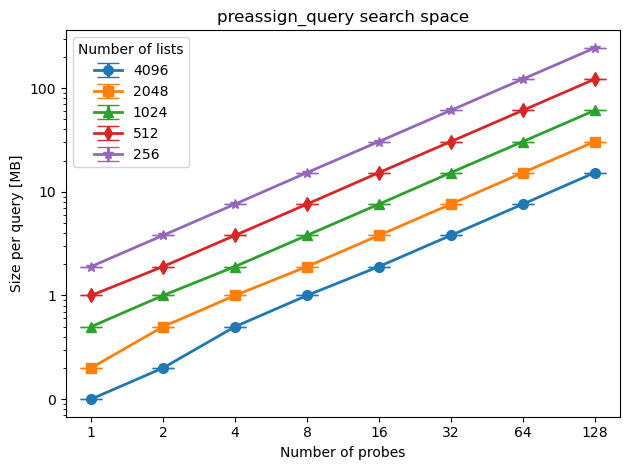

In [232]:
plot(centroids_df, 'search_space_size_mb', 'Size per query [MB]', 'preassign_query search space', yerr_col='std', yaxis_log=True)

**Execution Time**

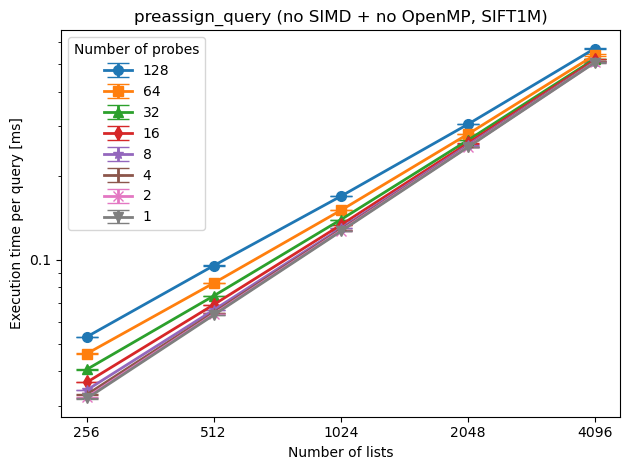

In [233]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='preassign_query (no SIMD + no OpenMP, SIFT1M)', legend_loc='upper left', mode='n_lists', yaxis_log=True, yformatter=s_to_ms_formatter)

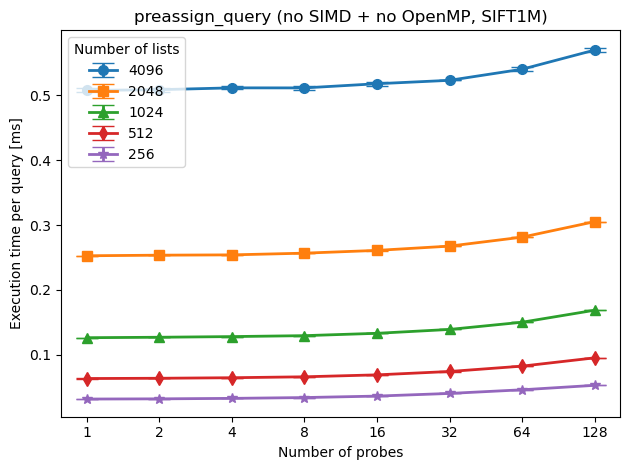

In [234]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='preassign_query (no SIMD + no OpenMP, SIFT1M)', legend_loc='upper left', yformatter=s_to_ms_formatter)

**Throughput**

- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probes`
- For a fixed `n_lists` and increasing `n_probes`, we expect the throughput to decrease since we need to compare against the current list of `n_probes` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

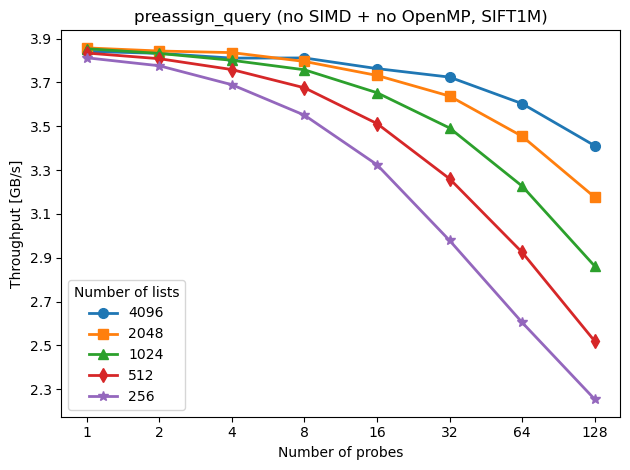

In [235]:
plot(df=centroids_df, y_col='mb_per_s', ylabel='Throughput [GB/s]', title='preassign_query (no SIMD + no OpenMP, SIFT1M)', yformatter=mb_to_gb_formatter)

## `search_preassigned`

In [236]:
search_df = results_to_df(parse_xml('Vanilla', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=0 SIM=0 NTH=16.xml', format='throughput'))
add_space_estimates(search_df)
add_search_throughput(search_df)
search_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,16,0.000548,1.353680e-06,3906.2,1.9,0.1,7131199.3,3482.0
1,256,2,16,0.001076,5.393330e-06,7812.5,3.8,0.1,7262510.1,3546.1
2,256,4,16,0.002098,3.208600e-06,15625.0,7.6,0.1,7446752.7,3636.1
3,256,8,16,0.004109,8.316200e-06,31250.0,15.3,0.1,7605830.6,3713.8
4,256,16,16,0.008057,5.088720e-06,62500.0,30.5,0.1,7757152.7,3787.7
5,256,32,16,0.015852,1.384890e-05,125000.0,61.0,0.1,7885639.3,3850.4
6,256,64,16,0.031233,2.684840e-06,250000.0,122.1,0.1,8004354.4,3908.4
7,256,128,16,0.062115,9.669950e-06,500000.0,244.1,0.1,8049546.6,3930.4
8,512,1,16,0.000277,1.221810e-06,1953.1,1.0,0.2,7063090.8,3448.8
9,512,2,16,0.000539,2.663030e-06,3906.2,1.9,0.2,7245860.6,3538.0


**Execution Time**

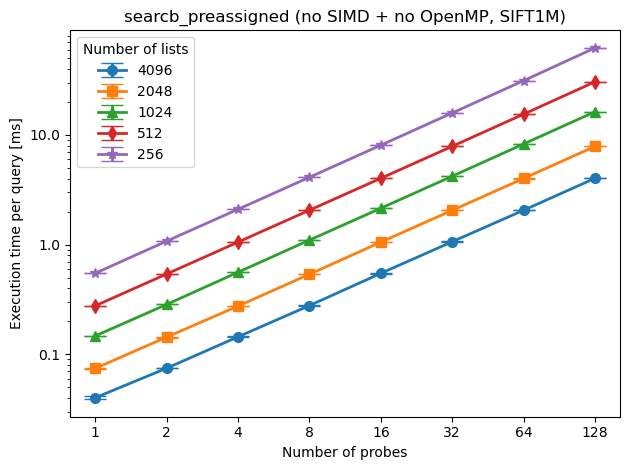

In [237]:
plot(df=search_df, y_col='mean', yerr_col='std', title='searcb_preassigned (no SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**
- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probes`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probes` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


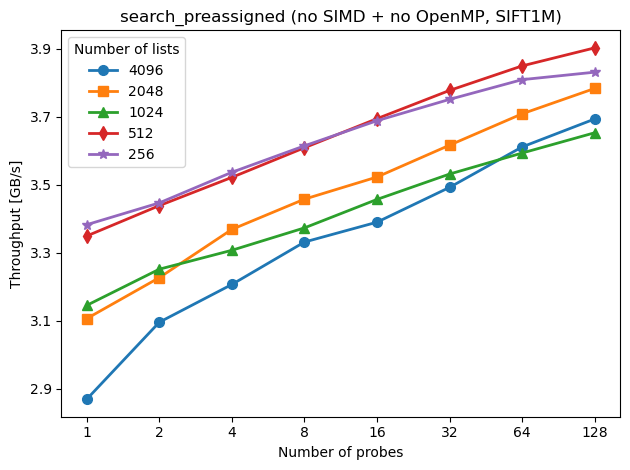

In [238]:
plot(df=search_df, y_col='mb_per_s', title='search_preassigned (no SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

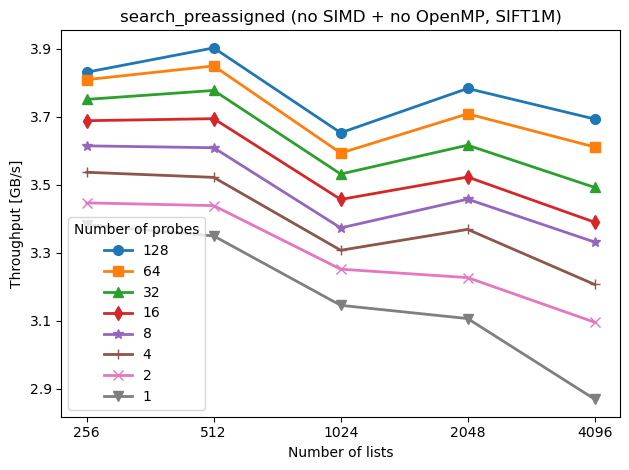

In [239]:
plot(df=search_df, y_col='mb_per_s', title='search_preassigned (no SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', mode='n_lists', yformatter=mb_to_gb_formatter)

# SIMD, no OpenMP

## `preassign_query()`

In [240]:
centroids_simd_df = results_to_df(parse_xml('SIMD', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=0 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_simd_df)
add_centroids_search_throughput(centroids_simd_df)
centroids_simd_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mean', invert=True)
centroids_simd_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,16,0.000007,1.524810e-07,3906.2,1.9,0.1,38194475.5,18649.6,4.766462
1,256,2,16,0.000007,1.163890e-08,7812.5,3.8,0.1,36730313.4,17934.7,4.626728
2,256,4,16,0.000007,1.406150e-09,15625.0,7.6,0.1,34184427.7,16691.6,4.404223
3,256,8,16,0.000008,8.779340e-08,31250.0,15.3,0.1,30164348.6,14728.7,4.034258
4,256,16,16,0.000010,2.704110e-08,62500.0,30.5,0.1,25193130.9,12301.3,3.591970
5,256,32,16,0.000013,5.328030e-09,125000.0,61.0,0.1,19031334.8,9292.6,3.017656
6,256,64,16,0.000018,7.390010e-09,250000.0,122.1,0.1,14200527.0,6933.9,2.563145
7,256,128,16,0.000024,2.698530e-08,500000.0,244.1,0.1,10682200.4,5215.9,2.214979
8,512,1,16,0.000014,1.653970e-08,1953.1,1.0,0.2,37840154.9,18476.6,4.696074
9,512,2,16,0.000014,3.694520e-08,3906.2,1.9,0.2,36656524.1,17898.7,4.579366


**Throughput**

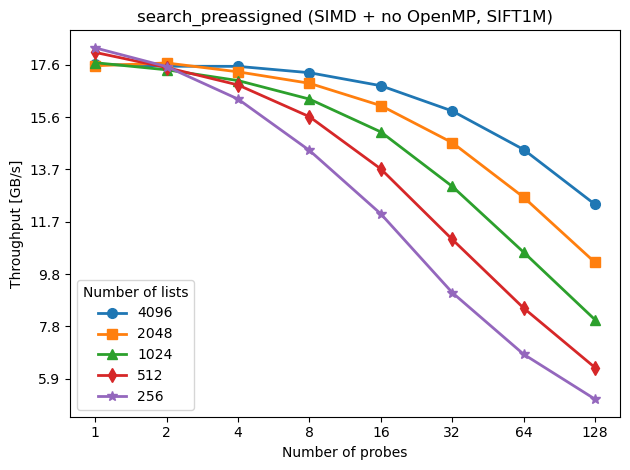

In [241]:
plot(df=centroids_simd_df, y_col='mb_per_s', title='preassign_query (SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD speed-up for preassign_query(): 4.0x


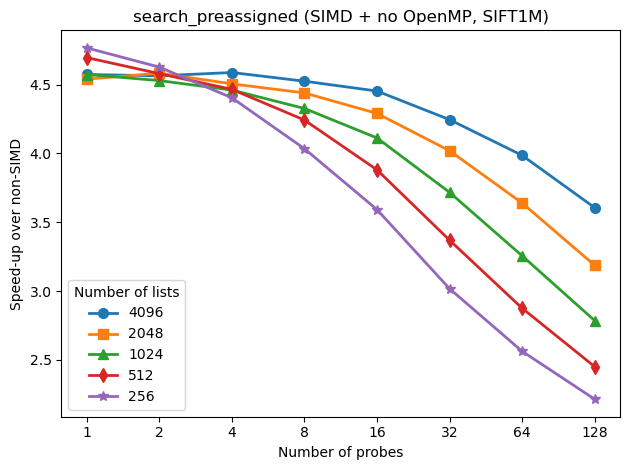

In [242]:
speedup = centroids_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_df, y_col='mean_speedup', title='preassign_query (SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD + non-OpenMP')

## `search_preassigned()`

In [243]:
search_simd_df = results_to_df(parse_xml('SIMD', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=0 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_df)
add_search_throughput(search_simd_df)
search_simd_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_df, column='mean', invert=True)
search_simd_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,16,0.000216,2.193500e-06,3906.2,1.9,0.1,18074719.8,8825.5,2.534597
1,256,2,16,0.000373,9.629360e-07,7812.5,3.8,0.1,20944422.6,10226.8,2.883910
2,256,4,16,0.000732,3.491890e-06,15625.0,7.6,0.1,21348049.0,10423.9,2.866759
3,256,8,16,0.001438,6.005210e-06,31250.0,15.3,0.1,21732629.5,10611.6,2.857364
4,256,16,16,0.002815,7.654600e-06,62500.0,30.5,0.1,22203906.5,10841.8,2.862378
5,256,32,16,0.005537,4.041310e-06,125000.0,61.0,0.1,22574790.3,11022.8,2.862772
6,256,64,16,0.010905,1.066640e-06,250000.0,122.1,0.1,22924633.0,11193.7,2.864020
7,256,128,16,0.021737,1.766000e-05,500000.0,244.1,0.1,23002571.7,11231.7,2.857623
8,512,1,16,0.000098,5.492140e-08,1953.1,1.0,0.2,19872933.7,9703.6,2.813631
9,512,2,16,0.000190,1.276850e-06,3906.2,1.9,0.2,20534738.0,10026.7,2.833996


**Execution Time**

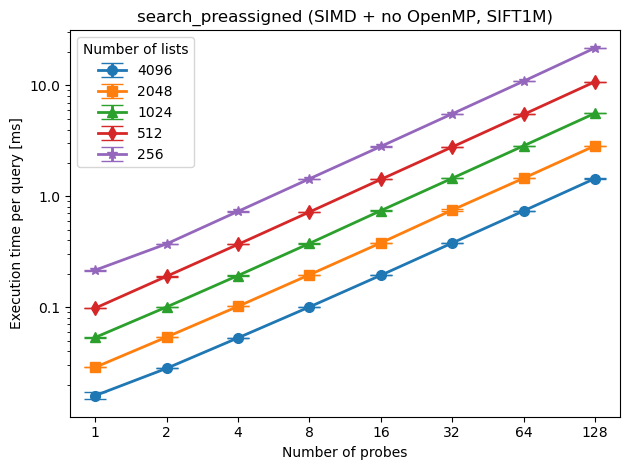

In [244]:
plot(df=search_simd_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**

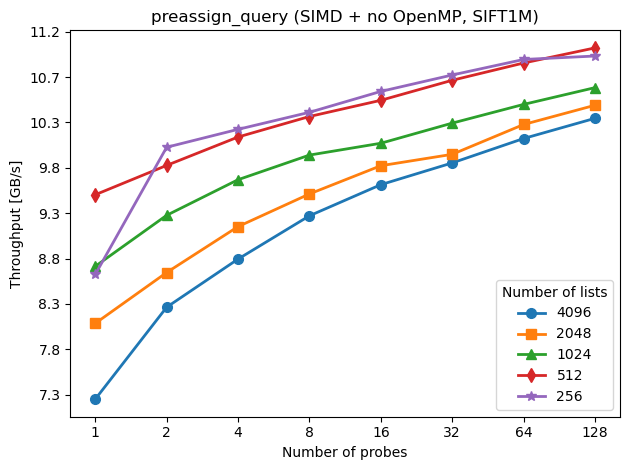

In [245]:
plot(df=search_simd_df, y_col='mb_per_s', title='search_preassigned (SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD speed-up for search_preassigned(): 2.8x


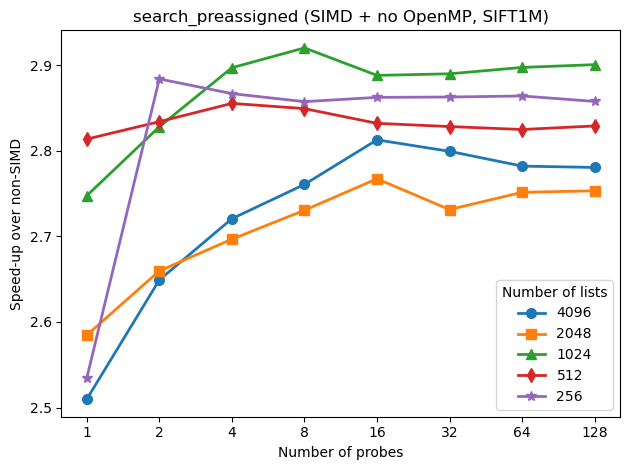

In [246]:
speedup = search_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_df, y_col='mean_speedup', title='search_preassigned (SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD', yformatter=speedup_formatter)

# SIMD, OpenMP (over queries)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 16 cores, each with 2 threads.
- OpenMP was configured to use up to `16` threads by configuring `OMP_NUM_THREADS`, an environment variable which sets the maximum thread count.

## `search_preassigned()`: Finding the optimal number of threads

In [329]:
def merge_results(subdir, filter_file, format):
  results = []
  for f in os.listdir(join('benchmarks', subdir)):
      if filter_file(f):
        params = get_file_params(f)
        for result in parse_xml(subdir, f, format=format):
          result['O'] = params['O']
          results.append(result)
  return results

threads_throughput_df = results_to_df(merge_results('max number of threads', lambda f: 'throughput' in f, 'throughput'))

threads_throughput_df = threads_throughput_df.sort_values(by=['O', 'max_n_threads'])
add_space_estimates(threads_throughput_df)
add_search_throughput(threads_throughput_df)
threads_throughput_df


,O,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
28,1,1,1024,16,16,0.000850,7.176640e-06,15625.0,7.6,0.5,18386917.2,8978.0
3,1,2,1024,16,16,0.000436,1.880860e-06,15625.0,7.6,0.5,35868417.4,17513.9
10,1,4,1024,16,16,0.000315,6.841650e-07,15625.0,7.6,0.5,49664822.0,24250.4
27,1,8,1024,16,16,0.000313,5.824660e-06,15625.0,7.6,0.5,49917257.2,24373.7
26,1,16,1024,16,16,0.000322,4.480570e-06,15625.0,7.6,0.5,48529366.1,23696.0
20,1,32,1024,16,16,0.000300,1.435350e-05,15625.0,7.6,0.5,52067019.0,25423.3
21,1,64,1024,16,16,0.000230,8.643790e-06,15625.0,7.6,0.5,67822727.7,33116.6
5,1,128,1024,16,16,0.000203,7.439950e-06,15625.0,7.6,0.5,77128499.8,37660.4
16,1,256,1024,16,16,0.000170,1.038130e-06,15625.0,7.6,0.5,91893386.0,44869.8
14,1,512,1024,16,16,0.000162,1.504620e-06,15625.0,7.6,0.5,96581180.7,47158.8


**Execution Time**

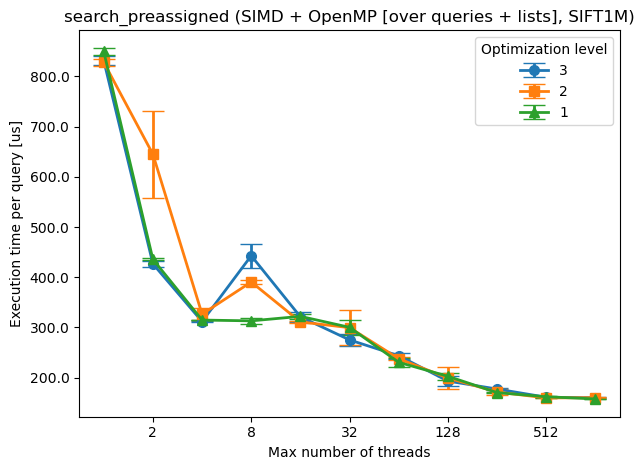

In [322]:
plot(df=threads_throughput_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [us]', mode='max_n_threads', yformatter=s_to_us_formatter)

**Throughput**

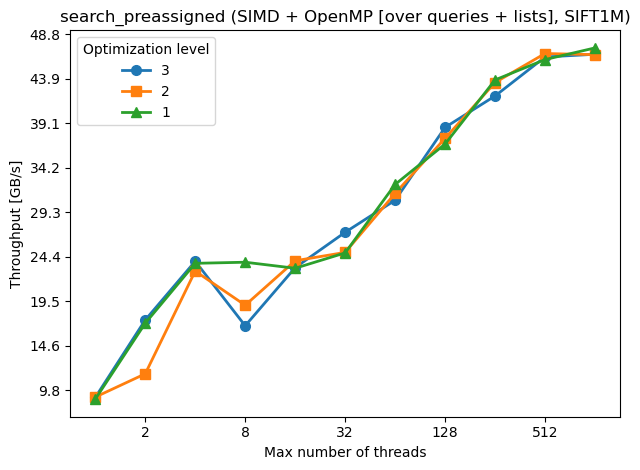

In [325]:
plot(df=threads_throughput_df, y_col='mb_per_s', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter)

**Latency**

In [338]:
threads_latency_df = results_to_df(merge_results('max number of threads', lambda f: 'latency' in f, 'latency'))
threads_latency_df = threads_latency_df.sort_values(by=['O', 'max_n_threads'])
threads_latency_df

,O,max_n_threads,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th
21,1,1,1024,16,16,0.000809,0.001272,0.004871
4,1,2,1024,16,16,0.000428,0.000697,0.003667
0,1,4,1024,16,16,0.000302,0.000481,0.003004
22,1,8,1024,16,16,0.000436,0.000696,0.001390
29,1,16,1024,16,16,0.000440,0.000707,0.002516
32,1,32,1024,16,16,0.000454,0.000738,0.003344
24,1,64,1024,16,16,0.000639,0.000982,0.003047
18,1,128,1024,16,16,0.001022,0.001503,0.003363
7,1,256,1024,16,16,0.001132,0.001737,0.003589
9,1,512,1024,16,16,0.002019,0.002560,0.003763


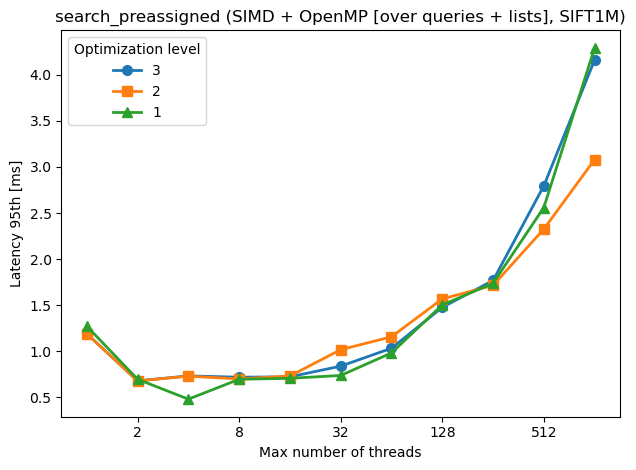

In [352]:
plot(df=threads_latency_df, y_col='latency_95th', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 95th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter)

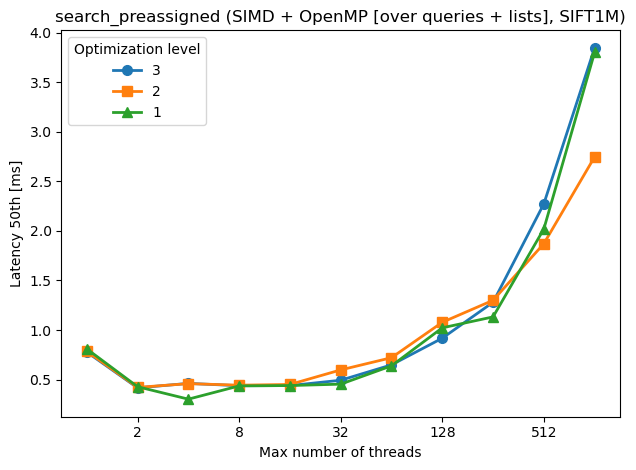

In [357]:
plot(df=threads_latency_df, y_col='latency_50th', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 50th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter)

## `preassign_query()`

In [264]:
centroids_simd_omp_df = results_to_df(parse_xml('OpenMP PMODE 1', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_simd_omp_df)
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_omp_df['mean_speedup'] = get_speedup(old_df=centroids_simd_df, new_df=centroids_simd_omp_df, column='mean', invert=True)
centroids_simd_omp_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,16,4.718300e-07,1.832810e-08,3906.2,1.9,0.1,542568297.9,264925.9,14.205413
1,16,256,2,16,7.807300e-07,4.015480e-08,7812.5,3.8,0.1,327898249.1,160106.6,8.927184
2,16,256,4,16,7.244010e-07,1.350050e-07,15625.0,7.6,0.1,353395426.0,172556.4,10.337907
3,16,256,8,16,6.567480e-07,9.047560e-08,31250.0,15.3,0.1,389799436.0,190331.8,12.922521
4,16,256,16,16,8.758860e-07,3.107730e-08,62500.0,30.5,0.1,292275478.8,142712.6,11.601396
5,16,256,32,16,9.572960e-07,6.487830e-08,125000.0,61.0,0.1,267419899.4,130576.1,14.051558
6,16,256,64,16,1.150550e-06,2.866720e-09,250000.0,122.1,0.1,222502281.5,108643.7,15.668593
7,16,256,128,16,1.499210e-06,1.261910e-08,500000.0,244.1,0.1,170756598.5,83377.2,15.985152
8,16,512,1,16,1.023770e-06,6.473760e-08,1953.1,1.0,0.2,500112329.9,244195.5,13.216445
9,16,512,2,16,9.693560e-07,3.101340e-08,3906.2,1.9,0.2,528185723.3,257903.2,14.409051


**Execution Time**

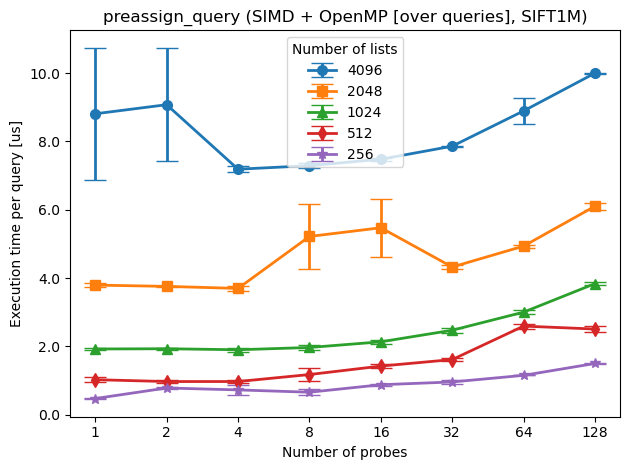

In [257]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, legend_loc='upper center')

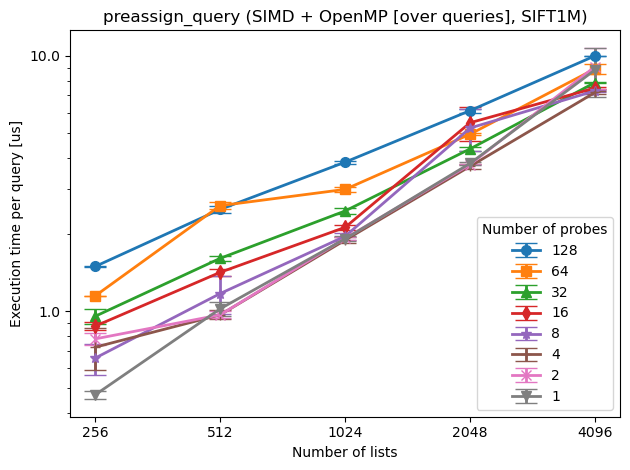

In [261]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, mode='n_lists', yaxis_log=True)

**Throughput**

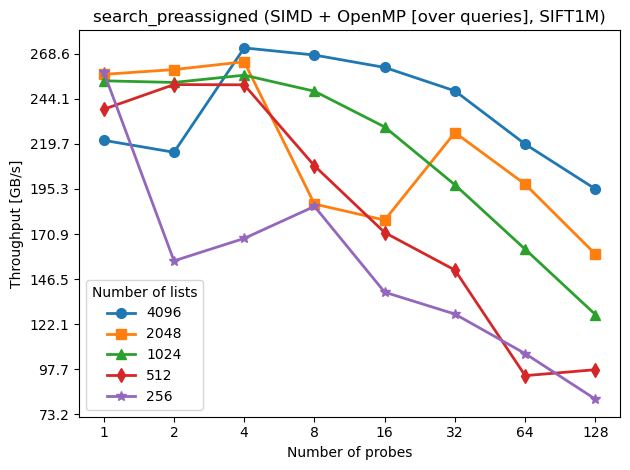

In [262]:
plot(df=centroids_simd_omp_df, y_col='mb_per_s', title='preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up for preassign_query(): 14.1x


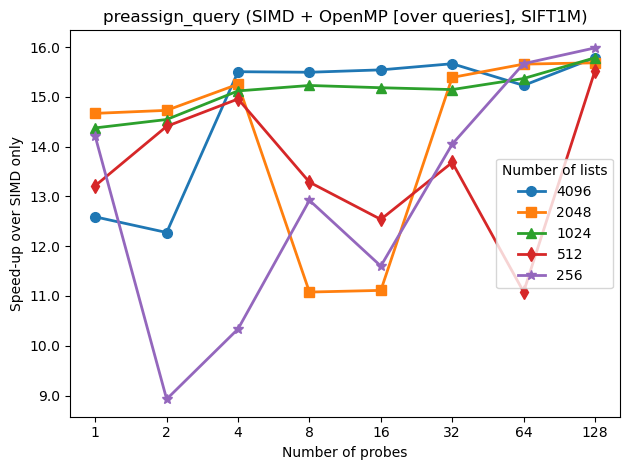

In [359]:
speedup = centroids_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mean_speedup', title='preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', yformatter=speedup_formatter)

## `search_preassigned()`

In [277]:
search_simd_omp_df = results_to_df(parse_xml('OpenMP PMODE 1', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_df)
add_search_throughput(search_simd_omp_df)
search_simd_omp_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_df, column='mean', invert=True)
search_simd_omp_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,16,0.000093,3.415280e-06,3906.2,1.9,0.1,41787461.8,20404.0,2.311929
1,16,256,2,16,0.000189,3.801300e-06,7812.5,3.8,0.1,41280065.1,20156.3,1.970934
2,16,256,4,16,0.000288,3.725940e-06,15625.0,7.6,0.1,54318730.1,26522.8,2.544435
3,16,256,8,16,0.000632,6.248540e-05,31250.0,15.3,0.1,49446906.7,24144.0,2.275238
4,16,256,16,16,0.001190,1.085480e-04,62500.0,30.5,0.1,52536460.3,25652.6,2.366091
5,16,256,32,16,0.002193,2.269110e-04,125000.0,61.0,0.1,57012022.7,27837.9,2.525473
6,16,256,64,16,0.003752,4.654900e-04,250000.0,122.1,0.1,66633083.6,32535.7,2.906615
7,16,256,128,16,0.007358,1.427840e-04,500000.0,244.1,0.1,67949461.9,33178.4,2.953994
8,16,512,1,16,0.000059,6.299320e-06,1953.1,1.0,0.2,33204918.1,16213.3,1.670861
9,16,512,2,16,0.000099,2.301360e-06,3906.2,1.9,0.2,39536437.2,19304.9,1.925344


**Execution Time**

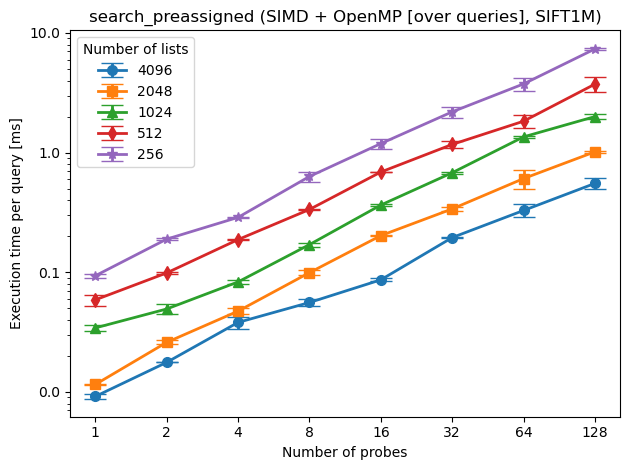

In [272]:
plot(df=search_simd_omp_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

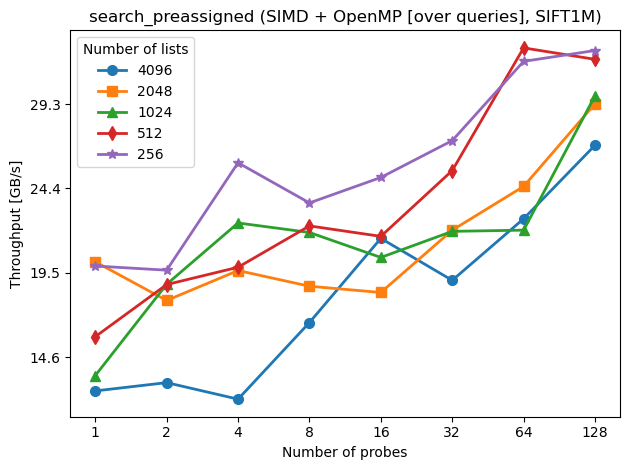

In [274]:
plot(df=search_simd_omp_df, y_col='mb_per_s', title='search_preassigned (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up over SIMD only: 2.2x


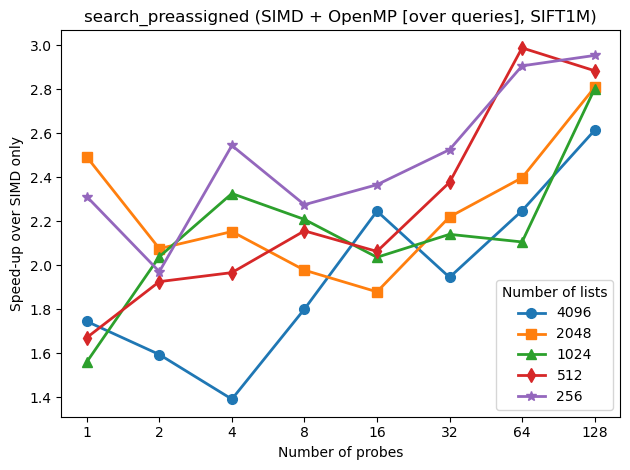

In [360]:
speedup = search_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over SIMD only: {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mean_speedup', title='search_preassigned (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only')

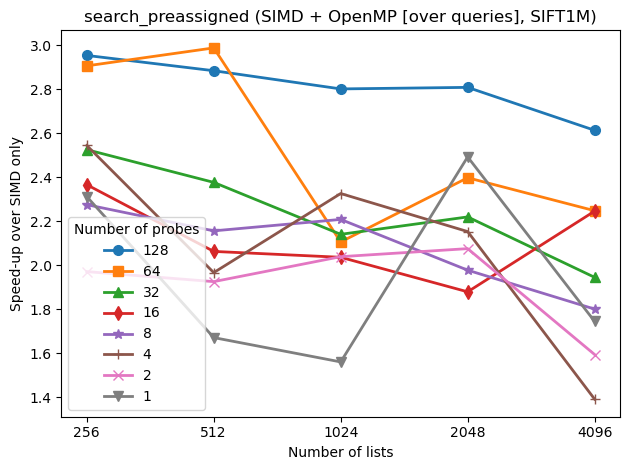

In [284]:
plot(df=search_simd_omp_df, y_col='mean_speedup', title='search_preassigned (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', mode='n_lists')

# SIMD, OpenMP (over queries and lists)

## `search_preassigned()`

In [295]:
search_simd_omp_pmode2_df = results_to_df(parse_xml('OpenMP PMODE 2', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=16 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_df)
add_search_throughput(search_simd_omp_pmode2_df)
search_simd_omp_pmode2_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_pmode2_df, column='mean', invert=True)
search_simd_omp_pmode2_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,16,0.000088,3.817430e-06,3906.2,1.9,0.1,44474705.0,21716.2,2.460603
1,16,256,2,16,0.000156,1.242790e-06,7812.5,3.8,0.1,49950768.5,24390.0,2.384920
2,16,256,4,16,0.000310,3.290140e-05,15625.0,7.6,0.1,50378686.5,24599.0,2.359873
3,16,256,8,16,0.000624,1.604620e-05,31250.0,15.3,0.1,50048286.6,24437.6,2.302910
4,16,256,16,16,0.001022,4.294270e-05,62500.0,30.5,0.1,61146820.9,29856.8,2.753877
5,16,256,32,16,0.001874,2.993050e-04,125000.0,61.0,0.1,66702953.1,32569.8,2.954754
6,16,256,64,16,0.003835,1.037570e-04,250000.0,122.1,0.1,65185648.7,31828.9,2.843476
7,16,256,128,16,0.007097,5.517690e-04,500000.0,244.1,0.1,70451013.3,34399.9,3.062745
8,16,512,1,16,0.000056,6.853170e-06,1953.1,1.0,0.2,34731224.7,16958.6,1.747665
9,16,512,2,16,0.000086,1.943940e-06,3906.2,1.9,0.2,45474600.8,22204.4,2.214521


**Execution Time**

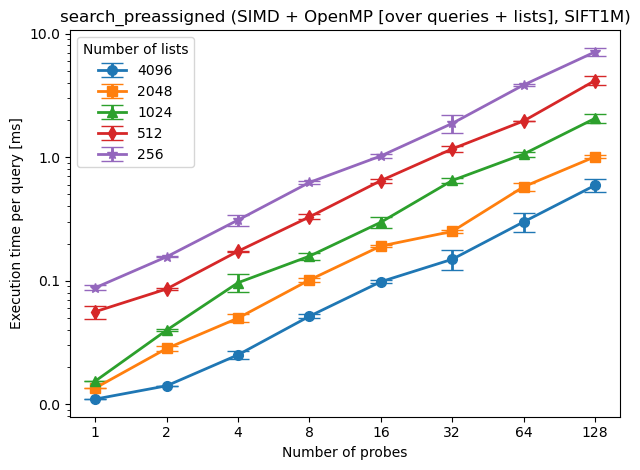

In [297]:
plot(df=search_simd_omp_pmode2_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

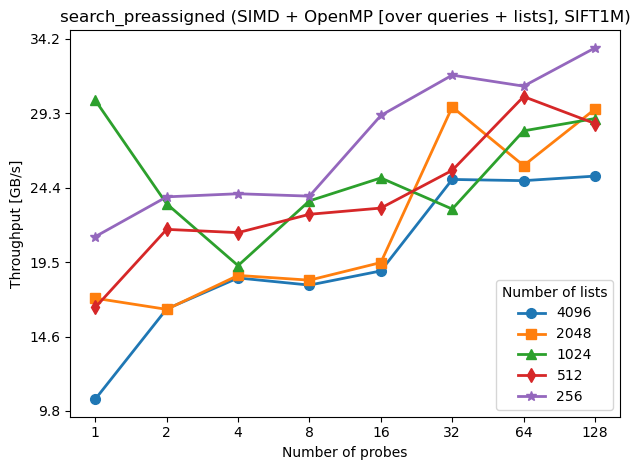

In [298]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: 2.4x


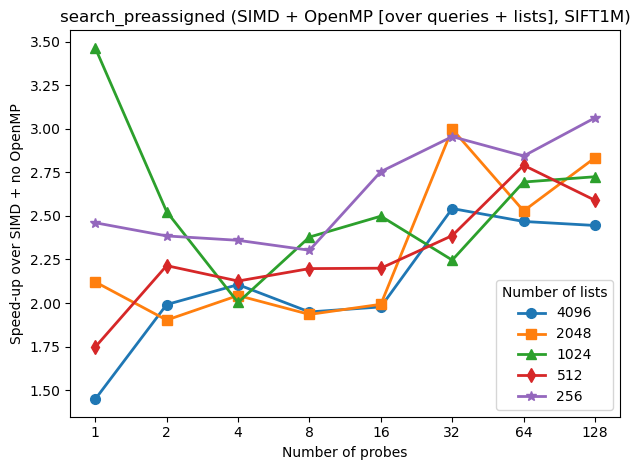

In [362]:
speedup = search_simd_omp_pmode2_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD + no OpenMP')

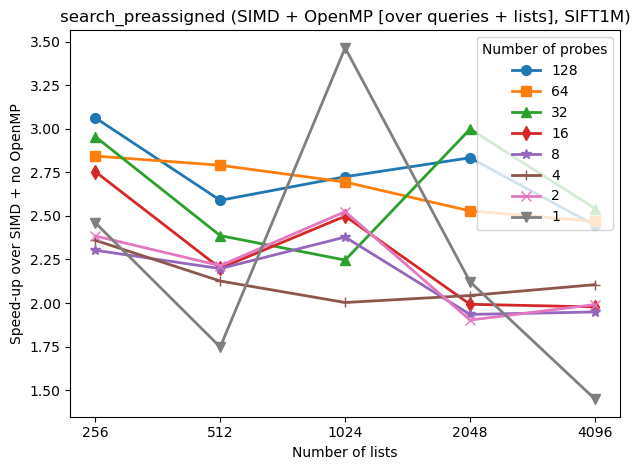

In [363]:
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD + no OpenMP', mode='n_lists')

### Varying `n_probes` and `n_results`

In [364]:
search_simd_omp_pmode2_varying_nresults_df = results_to_df(parse_xml('number of results', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=100000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=1024 NPR=1,2,4,8,16,32,64,128 NRE=1,2,4,8,16,32,64,128 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_varying_nresults_df)
add_search_throughput(search_simd_omp_pmode2_varying_nresults_df)
search_simd_omp_pmode2_varying_nresults_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,16,1024,1,1,0.000028,1.923090e-06,976.6,0.5,0.5,35134425.3,17155.5
1,16,1024,1,2,0.000029,1.320450e-06,976.6,0.5,0.5,33756178.5,16482.5
2,16,1024,1,4,0.000026,1.582130e-06,976.6,0.5,0.5,37897367.4,18504.6
3,16,1024,1,8,0.000021,1.231360e-07,976.6,0.5,0.5,45553985.2,22243.2
4,16,1024,1,16,0.000013,8.358810e-07,976.6,0.5,0.5,75718339.6,36971.8
...,...,...,...,...,...,...,...,...,...,...,...
59,16,1024,128,8,0.002221,3.216730e-04,125000.0,61.0,0.5,56287036.9,27483.9
60,16,1024,128,16,0.002019,3.353520e-05,125000.0,61.0,0.5,61904172.3,30226.6
61,16,1024,128,32,0.002109,1.872960e-04,125000.0,61.0,0.5,59259118.8,28935.1
62,16,1024,128,64,0.002484,8.539070e-05,125000.0,61.0,0.5,50316794.5,24568.7


**Execution Time**

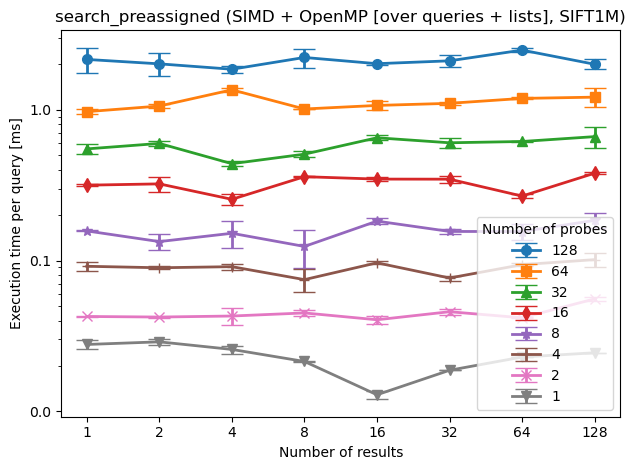

In [372]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, mode='n_results', yaxis_log=True)

**Throughput**
- critical region

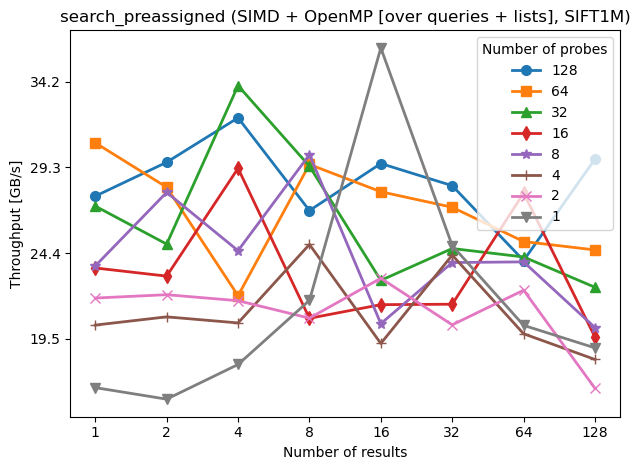

In [368]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mb_per_s', title='search_preassigned (SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, mode='n_results')

**Recall**


In [149]:
search_recall_simd_omp_pmode2_df = results_to_df(parse_xml_recall('preassign_query_recall_simd_omp_pmode2.xml'))
# add_space_estimates(search_recall_simd_omp_pmode2_df)
# add_search_throughput(search_recall_simd_omp_pmode2_df)
search_recall_simd_omp_pmode2_df

OSError: Error reading file 'search_preassigned_recall_simd_omp_pmode2.xml': failed to load external entity "search_preassigned_recall_simd_omp_pmode2.xml"

**old Recall measurements**

In [ ]:
n_lists_arr = []
n_probe_arr = []
recall_at_1_arr = []
with open('recall/measurements.log', 'r') as f:
    for line in f:
        if line.startswith('Inserted'):
          continue
        value = line.strip().split(' ')[1]
        if line.startswith('n_lists'):
            n_lists_arr.append(int(value))
        elif line.startswith('n_probes'):
            n_probe_arr.append(int(value))
        elif line.startswith('Recall@1'):
            recall_at_1_arr.append(float(value))
measurements = list(zip(n_lists_arr, n_probe_arr, recall_at_1_arr))
def get_plot_data(n_lists):
    recall_at_1 = [x[2] for x in measurements if x[0] == n_lists]
    n_probes = [x[1] for x in measurements if x[0] == n_lists]
    return n_probes, recall_at_1

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.set_prop_cycle(marker_cycler)

bars = []
for n_lists in sorted(set(n_lists_arr)):
    bars.append(ax.plot(
        get_plot_data(n_lists)[0],
        get_plot_data(n_lists)[1],  
        label=f"{n_lists} lists"
    ))
ax.set_title('Index: Recall@1 (no SIMD + no OpenMP, SIFT1M)')

ax.set_xlabel("Number of probes")
ax.set_ylabel("Recall@1")

ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.legend()
plt.savefig('recall/index-recall-at-1.jpg', dpi=300)
plt.show()
